In [5]:
# One-time setup: run this cell, then restart the kernel if needed
! pip install -q "transformers" "datasets" "protobuf<5"


In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "Hello, how are you?"
# tokenize and encode the text
encoding = tokenizer.encode(text)
print("Token IDs:", encoding)

# convert token ids back to text
decoded_text = tokenizer.decode(encoding)
print("Decoded Text:", decoded_text)


Token IDs: [101, 7592, 1010, 2129, 2024, 2017, 1029, 102]
Decoded Text: [CLS] hello, how are you? [SEP]


In [12]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForNextSentencePrediction, Trainer, TrainingArguments
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [13]:
sentences=[
    ("The sky is blue.", "The sun is bright.", 1),
    ("The sky is blue.", "The grass is green.", 0),
    ("Cats are great pets.", "Dogs are also great pets.", 0),
    ("I love programming.", "Coding is fun.", 1),
    ("The earth revolves around the sun.", "The sun is a star.", 1),
    ("Apples are red.", "Bananas are yellow.", 0)
]
dataset=Dataset.from_dict({
    "sentence1":[s[0] for s in sentences],
    "sentence2":[s[1] for s in sentences],
    "label":[s[2] for s in sentences]
})
train_test_split=dataset.train_test_split(test_size=0.2)
train_dataset=train_test_split['train']
test_dataset=train_test_split['test']

tokenize the dataset 

In [14]:
from transformers import BertTokenizer

tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples['sentence1'],examples['sentence2'],padding="max_length",truncation=True,max_length=128)

train_dataset=train_dataset.map(tokenize_function,batched=True)
test_dataset=test_dataset.map(tokenize_function,batched=True)

train_dataset.set_format(type='torch',columns=['input_ids','token_type_ids','attention_mask','label'])
test_dataset.set_format(type='torch',columns=['input_ids','token_type_ids','attention_mask','label'])

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [15]:
model=AutoModelForNextSentencePrediction.from_pretrained("bert-base-uncased")

In [16]:
from transformers import BertTokenizer, BertForNextSentencePrediction, Trainer, TrainingArguments

In [17]:
model=BertForNextSentencePrediction.from_pretrained("bert-base-uncased")

In [21]:
training_args=TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    report_to=[]  # Disable MLflow and other integrations
)

In [23]:
def compute_metrics(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)
    acc=accuracy_score(labels,preds)
    return {"accuracy":acc}

training API 

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()

eval_results = trainer.evaluate()
print(f"\nEvaluation Results: {eval_results}")

Step,Training Loss



Evaluation Results: {'eval_loss': 5.6426849365234375, 'eval_accuracy': 0.5, 'eval_runtime': 0.3551, 'eval_samples_per_second': 5.632, 'eval_steps_per_second': 2.816, 'epoch': 3.0}


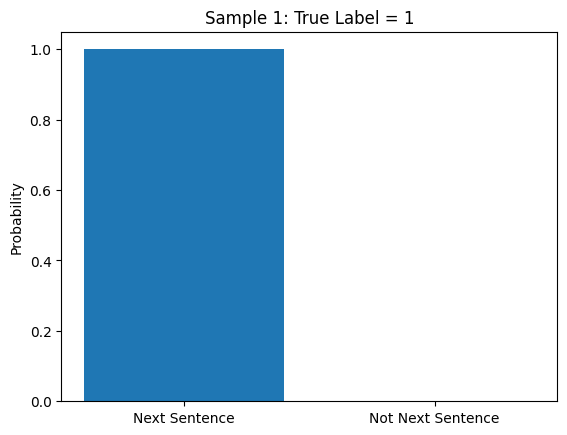

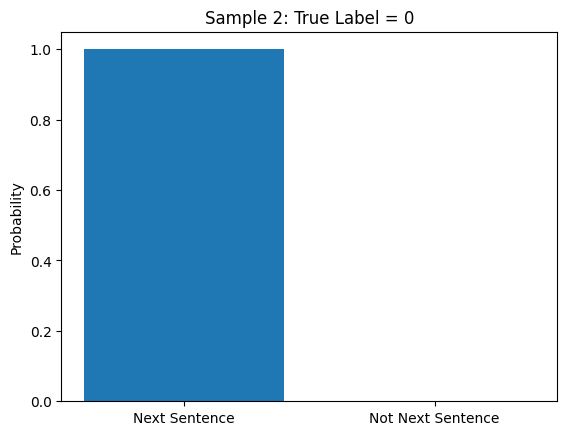

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

num_samples = min(5, len(test_dataset))

for i in range(num_samples):  
    plt.figure(figsize=(8, 5))
    plt.bar(['Next Sentence', 'Not Next Sentence'], probs[i])
    plt.title(f"Sample {i+1}: True Label = {test_dataset[i]['label']}")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()